### Notebook's Goals
---
In this notebook we are going to use the XGBoost algorithm to work with Time Series.

And we are going to focus on the **"Benchmark "** mode in which what we are looking for is to quickly obtain a simple and functional notebook, performing the task from start to finish without getting deeply involved in any stage of the development, and thus be able to have a first benchmark result (which will be the minimal scord acceptable) to be able to compare more elaborated notebooks.

The dataset we are going to work with in this notebook contains about 300 Time Series covering the period January'2013 - September'2015. Therefore we are going to work with Multivariate Time Series.

Each of these Time Series represent the DAILY sales of an item in a store and city. The objective is to predict the *TOTAL SALES FOR THE MONTH OF OCTOBER'2015.

In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.21.6
Pandas version 1.3.5
XGBoost version 1.6.2


In [4]:
# KAGGLE TRAIN
DATA_PATH = "/kaggle/input/nuclio15-dsc-str-1022"
TRAIN_CSV_PATH = os.path.join(DATA_PATH, "sales_train_merged.csv")

# LOCAL TRAIN
# CWD = os.getcwd()
# DATA_PATH = os.path.join(CWD, "data")
# TRAIN_CSV_PATH = os.path.join(DATA_PATH, "ts_kaggle_sales_train_merged.csv")

ORDER_COLUMNS = [
    'DATE',
    'UNIQUE_ID',
    'CITY_NAME',
    'CITY_ID',
    'SHOP_NAME',
    'SHOP_ID',
    'ITEM_CATEGORY_NAME',
    'ITEM_CATEGORY_ID',
    'ITEM_NAME',
    'ITEM_ID',
    'ITEM_PRICE',
    'SALES'
]


### Helpers Time Series

We define several auxiliary functions to be used throughout the notebook.

In [5]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    df = preprocess_df(df)
    
    return df

In [6]:
def preprocess_df(df):
    '''
    Preprocess df: upper columns, str date to datetime etc.
    '''
    df.columns = map(str.upper, df.columns)
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CITY_ID"] = OrdinalEncoder().fit_transform(df[["CITY"]])
    
    df.rename(columns = {"CITY":"CITY_NAME", "ITEM_CNT_DAY":"SALES"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df


### Data Loading



In [7]:
df = load_data(path_data_file = TRAIN_CSV_PATH)
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
75068,2015-04-17,50-20949,Tyumen,18.0,"Tyumen SC ""Goodwin""",50,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,1.0
30979,2014-02-23,6-7856,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Juegos PC - Otras publicaciones,28,Mundo de Warcraft. Tiempo de juego Mapa de pag...,7856,799.0,1.0
60994,2014-12-29,59-17717,Yaroslavl,24.0,"centro comercial Yaroslavl ""Altair""",59,Herramientas de sistema,79,Recibir fondos para 1c-online,17717,300.0,1.0
9166,2013-06-09,42-7856,San Petersburgo,14.0,"San Petersburgo TK ""Nevsky Centro""",42,Juegos PC - Otras publicaciones,28,Mundo de Warcraft. Tiempo de juego Mapa de pag...,7856,799.0,1.0
40749,2014-05-07,57-4248,Yakutsk,23.0,"Yakutsk Ordzhonikidze, 56",57,Juegos - XBOX 360,23,Kinect Sports Ultimate (solo MS Kinect) [Xbox ...,4248,1048.7,1.0


We'll check what kind of data is there in our data set.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87963 entries, 0 to 87962
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                87963 non-null  datetime64[ns]
 1   UNIQUE_ID           87963 non-null  object        
 2   CITY_NAME           87963 non-null  object        
 3   CITY_ID             87963 non-null  float64       
 4   SHOP_NAME           87963 non-null  object        
 5   SHOP_ID             87963 non-null  int64         
 6   ITEM_CATEGORY_NAME  87963 non-null  object        
 7   ITEM_CATEGORY_ID    87963 non-null  int64         
 8   ITEM_NAME           87963 non-null  object        
 9   ITEM_ID             87963 non-null  int64         
 10  ITEM_PRICE          87963 non-null  float64       
 11  SALES               87963 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 8.7+ MB


Tenemos un total de 299 Series Temporales en el dataset:

In [9]:
df["UNIQUE_ID"].nunique()

299

Veamos cuales son las fechas min y max de nuestro dataset:

In [10]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [11]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-01 00:00:00
Max date is 2015-09-30 00:00:00



### Grouping sales by month


In this job we are asked to predict the total sales for the month of October'2015 for each ITEM_ID and SHOP_ID.

However, if we look at the dataset closely, we will see that the reported sales come per day. Right now we have 2 options: 

1. we can train a model with the daily sales, predict 30 days and then sum the 30 predictions and get the value for October'2015.
2. Group the sales by month, train a model with the monthly sales and make 1 predict (month of October'2015).

Clearly the second option is much simpler, for this reason we will follow this approach.

Note: If we look closely, UNIQUE_ID = SHOP_ID + ITEM_ID.

In [12]:
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
61921,2014-12-30,28-4870,Moscú,7.0,"centro comercial de Moscú ""MEGA Teply Stan"" II",28,Juegos - XBOX 360,23,"Minecraft [Xbox 360, versión en inglés]",4870,999.0,1.0
68128,2015-02-12,42-20949,San Petersburgo,14.0,"San Petersburgo TK ""Nevsky Centro""",42,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,3.0
24182,2013-12-02,18-20949,Krasnoyarsk,5.0,"Krasnoyarsk SC ""Junio""",18,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,5.0,1.0
65661,2015-01-08,46-5822,Posad,11.0,"Posad TC ""7YA""",46,Las tarjetas de pago - PSN,35,PlayStation Tienda Reposición de la billetera:...,5822,1049.0,1.0
81207,2015-07-20,11-20949,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949,4.0,1.0


Since we are going to train our model with monthly variables, we take advantage of the operation to construct a total of 5 variables: 

1. Total sales
2. Total revenue (price x quantity)
3. Unique days that had sales
4. Total transactions for the month 
5. Average price for the month

In [13]:
df["REVENUE"] = df["ITEM_PRICE"] * df["SALES"]
df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
df["TOTAL_TRANSACTIONS"] = df["SALES"]

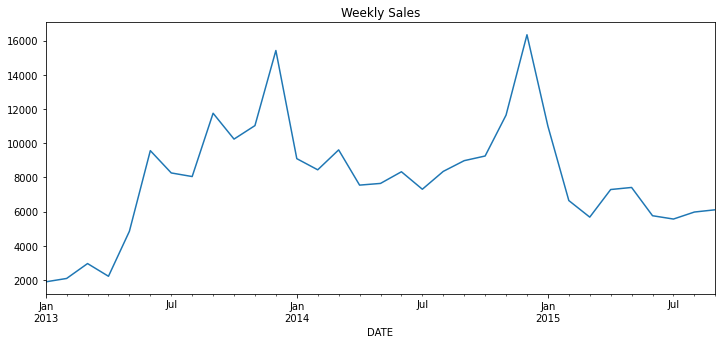

In [14]:
df.set_index("DATE").resample("M")["SALES"].sum().plot(figsize = (12, 5), title = "Weekly Sales");

We must take into account the item_id and the shop_id before doing the resample.

Let's see how we can combine the groupby with resample.

In [15]:
df_year_agg = df.set_index("DATE").groupby(["CITY_NAME"]).resample("Y").agg(
    {
        "SALES":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "ITEM_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES":"YEAR_SALES",
        "REVENUE":"YEAR_REVENUE",
        "ITEM_PRICE":"YEAR_MEAN_PRICE"
    }
).reset_index()

In [16]:
df1=df.set_index("DATE").resample("d").sum()

In [17]:
df1.isna().sum()#sort_values('DATE')#, ascending=False)

CITY_ID               0
SHOP_ID               0
ITEM_CATEGORY_ID      0
ITEM_ID               0
ITEM_PRICE            0
SALES                 0
REVENUE               0
TOTAL_TRANSACTIONS    0
dtype: int64

In [18]:
df1=df.set_index("DATE").resample("d").sum()
df2=pd.DataFrame(df1['SALES'])
df2
media_movil_3=np.mean(df2[:7])
media_movil_3

SALES    71.714286
dtype: float64

In [19]:
media_movil_3=np.mean(df2[1:3])
media_movil_3

SALES    94.5
dtype: float64

In [20]:
df.groupby('CITY_NAME').get_group('Surgut')['ITEM_CATEGORY_ID'].value_counts()

71    621
19    234
23    214
79    202
35    197
30    176
Name: ITEM_CATEGORY_ID, dtype: int64

In [21]:
# Implement in class

df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
    {
        "SALES":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "ITEM_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES":"MONTHLY_SALES",
        "REVENUE":"MONTHLY_REVENUE",
        "ITEM_PRICE":"MONTHLY_MEAN_PRICE"
    }
).reset_index()

In [22]:
df_monthly_agg["CHECK"] = df_monthly_agg["UNIQUE_DAYS_WITH_SALES"] == df_monthly_agg["TOTAL_TRANSACTIONS"]

In [23]:
df_monthly_agg

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
0,11-20949,2013-04-30,1.0,3.0,1,1,3.0,True
1,11-20949,2013-05-31,4.0,12.0,3,3,3.0,True
2,11-20949,2013-06-30,32.0,96.0,14,14,3.0,True
3,11-20949,2013-07-31,45.0,135.0,20,20,3.0,True
4,11-20949,2013-08-31,59.0,177.0,25,25,3.0,True
...,...,...,...,...,...,...,...,...
8741,7-5822,2015-05-31,7.0,8043.0,7,7,1149.0,True
8742,7-5822,2015-06-30,10.0,11490.0,5,5,1149.0,True
8743,7-5822,2015-07-31,4.0,4596.0,3,3,1149.0,True
8744,7-5822,2015-08-31,7.0,8043.0,5,5,1149.0,True


In [24]:
df_monthly_agg.groupby('UNIQUE_ID').sum().sort_values('UNIQUE_DAYS_WITH_SALES')

,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
UNIQUE_ID,,,,,,
24-2308,229.0,108152.74,162,175,12799.548026,29
31-15256,214.0,246579.00,165,165,34968.583333,33
25-16287,284.0,56475.80,167,167,3776.980000,19
3-17717,237.0,235497.00,167,167,19437.068639,32
55-6429,201.0,54242.00,170,170,8797.604396,29
...,...,...,...,...,...,...
42-20949,10068.0,50339.50,803,803,144.998208,30
22-20949,4331.0,21532.33,824,824,149.357137,30
31-20949,19503.0,97506.43,832,832,144.987011,30


Next we'll check is we are missing dates in our dataset.

Since our data set goes from jenuary 2012 to september 2015, is a total of 33 months

In [25]:
check_months = df_monthly_agg.groupby("UNIQUE_ID").size()
check_months.sample(3)

UNIQUE_ID
28-20949    30
31-3719     33
31-2252     33
dtype: int64

In [26]:
check_months[check_months != 33].shape

(173,)

We have a total of 173 incomplete Time Series (i.e., they are missing at least 1 month of records).

The reason for these is that we only have the reported sales. If one day or in one month there are no sales, we do not have these records in our original df.

Next we are going to generate a dataframe with all the historical records and also with the month of October'2015 (predict month).

In [27]:
DATE_PREDICTION = np.datetime64("2015-10-31")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")
date_range

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

In [28]:
unique_id = sorted(df_monthly_agg["UNIQUE_ID"].unique())
unique_id[:3]

['11-20949', '11-4181', '12-11365']

In [29]:
len(unique_id)

299

We generate all combinations between months and unique_id.

In [30]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "UNIQUE_ID"])
len(cartesian_product) 

10166

In [31]:
# 10166 son 34 meses por todas las combinaciones de unique_id
34 * 299

10166

We cross our Cartesian product with the dataframe grouped by months and containing the historical sales.

In [32]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','UNIQUE_ID'], how = 'left')

print(full_df.shape)


(10166, 2)
(10166, 8)


In [33]:
full_df.sample(5)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
6176,2014-09-30,44-20949,21.0,105.0,16.0,16.0,5.0,True
6565,2014-10-31,59-20949,90.0,450.0,29.0,29.0,5.0,True
1190,2013-04-30,6-5822,14.0,14686.0,9.0,9.0,1049.0,True
243,2013-01-31,55-6429,NaN,NaN,NaN,NaN,NaN,NaN
8284,2015-04-30,47-3732,3.0,10197.0,3.0,3.0,3399.0,True


Ones we've done this we'll add some importan data to the data set

In [34]:
add_info = df[
    ["UNIQUE_ID", "CITY_NAME", "CITY_ID", "SHOP_NAME", "SHOP_ID", "ITEM_CATEGORY_NAME", "ITEM_CATEGORY_ID", "ITEM_NAME", "ITEM_ID"]
].drop_duplicates()

add_info.head(3)

,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,25-2574,Moscú,7.0,"Moscú SEC ""Atrium""",25,Música - CD de la producción local,55,Del Rey Lana Nació para morir la edición de Pa...,2574
10,25-2808,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808
28,25-2308,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Call of Duty: Black Ops II [PC, Jewel, versión...",2308


In [35]:
add_info.shape

(299, 9)

In [36]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "UNIQUE_ID"
)

print(full_df.shape)

(10166, 8)
(10166, 16)



### Data Imputation

In [37]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [38]:
full_df.isnull().sum()

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES             1420
MONTHLY_REVENUE           1420
UNIQUE_DAYS_WITH_SALES    1420
TOTAL_TRANSACTIONS        1420
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [39]:
full_df["MONTHLY_SALES"].fillna(0, inplace = True)
full_df["MONTHLY_REVENUE"].fillna(0, inplace = True)
full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)

In [40]:
full_df.isnull().sum()
#media_movil_7=np.mean(full_df[]

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES                0
MONTHLY_REVENUE              0
UNIQUE_DAYS_WITH_SALES       0
TOTAL_TRANSACTIONS           0
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [41]:
# implementar en clase diferentes estrategias de imputación
sample_series = full_df[full_df["UNIQUE_ID"] == "7-17717"][["DATE", "UNIQUE_ID", "MONTHLY_MEAN_PRICE"]]
sample_series

,DATE,UNIQUE_ID,MONTHLY_MEAN_PRICE
296,2013-01-31,7-17717,449.000000
595,2013-02-28,7-17717,428.000000
894,2013-03-31,7-17717,619.000000
1193,2013-04-30,7-17717,390.000000
1492,2013-05-31,7-17717,599.000000
1791,2013-06-30,7-17717,NaN
2090,2013-07-31,7-17717,281.745000
2389,2013-08-31,7-17717,239.400000
2688,2013-09-30,7-17717,333.000000
2987,2013-10-31,7-17717,499.000000


In [42]:
full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(
    lambda series: series.backfill().ffill()
)

## New variables

In [43]:
add_info2 = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
    {
        "REVENUE":np.sum,
    }
).rename(
    columns = {
        "REVENUE":"MONTHLY_REVENUE",
    }
).reset_index()

add_info2

,UNIQUE_ID,DATE,MONTHLY_REVENUE
0,11-20949,2013-04-30,3.0
1,11-20949,2013-05-31,12.0
2,11-20949,2013-06-30,96.0
3,11-20949,2013-07-31,135.0
4,11-20949,2013-08-31,177.0
...,...,...,...
8741,7-5822,2015-05-31,8043.0
8742,7-5822,2015-06-30,11490.0
8743,7-5822,2015-07-31,4596.0
8744,7-5822,2015-08-31,8043.0


In [44]:
#del df, cartesian_product, unique_id, date_range, add_info, sample_series, check_months

### EDA

### --> 1. EDA: Global Sales


In [45]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [46]:
y = full_df.set_index("DATE").resample("M")["MONTHLY_SALES"].sum()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


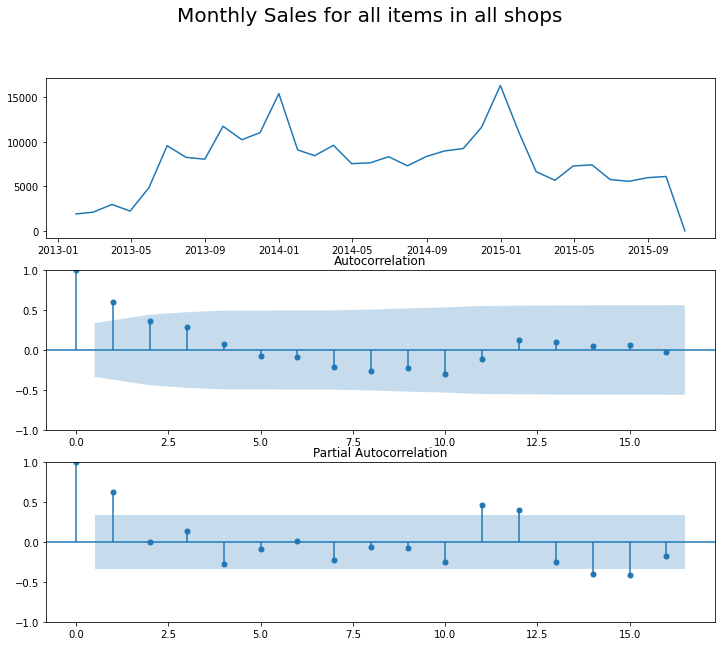

In [47]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Important note: we are using the acf and pacf graph, but we are not going to train an ARIMA model.

To solve the problem we are facing: 299 different Time Series we would have to train 299 ARIMAs. On the other hand, with the XGBoost algorithm we could train 1 single model.

However, unlike ARIMA (which internally constructs the necessary variables), for XGBoost we must be explicit and supply each and every one of the necessary variables.

From the previous graph we can already see that lag variables can be very relevant.

### --> 2. EDA: Top 3 Cities


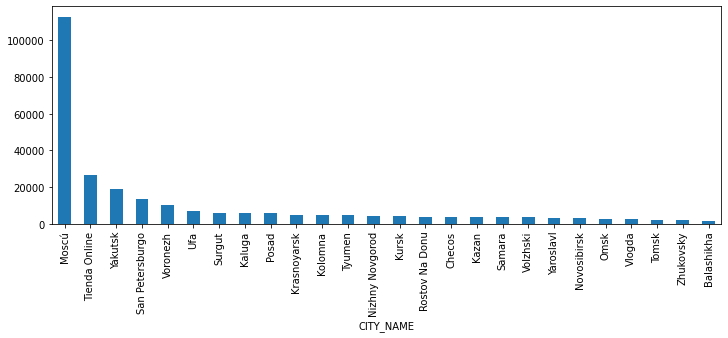

In [48]:
(
    full_df.
    groupby(["CITY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### --> 3. EDA: Top 3 Categories


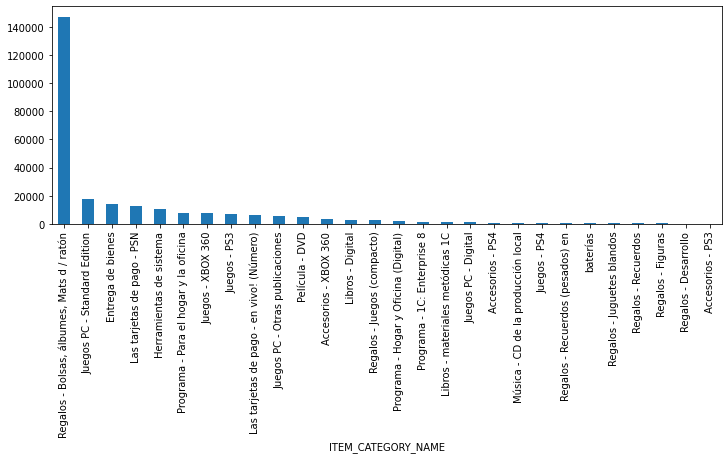

In [49]:
(
    full_df.
    groupby(["ITEM_CATEGORY_NAME"])
    ["MONTHLY_SALES"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);


### Build Time Series Features 


In [50]:
full_df.head()

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,2013-01-31,11-20949,0.0,0.0,0.0,0.0,3.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,"Regalos - Bolsas, álbumes, Mats d / ratón",71,Paquete corporativo Mike 1C Interés blanco (34...,20949
1,2013-01-31,11-4181,0.0,0.0,0.0,0.0,707.000000,Zhukovsky,25.0,Zhukovsky calle. 39m² Chkalov,11,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181
2,2013-01-31,12-11365,35.0,43300.0,12.0,12.0,1511.512626,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (EMS),11365
3,2013-01-31,12-11369,42.0,21220.0,12.0,12.0,572.715278,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (correo),11369
4,2013-01-31,12-11370,62.0,30750.0,16.0,16.0,699.776786,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega (en Moscú),11370


In [51]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df_

In [52]:
GB_LIST_SHOP_ID = ["DATE", "SHOP_ID", "ITEM_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_SHOP_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_shop_id.sample(10)

DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM


,DATE,SHOP_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG1
1152,2013-04-30,55,13342,0.0,0.0
9182,2015-07-31,45,20949,17.0,12.0
4824,2014-05-31,16,20949,73.0,86.0
3880,2014-01-31,58,12134,22.0,31.0
8305,2015-04-30,50,7893,1.0,0.0
9106,2015-07-31,31,32,5.0,6.0
8084,2015-04-30,6,5823,3.0,10.0
1331,2013-05-31,28,21404,0.0,0.0
3104,2013-11-30,28,3732,38.0,141.0
8156,2015-04-30,25,3734,5.0,7.0


In [53]:
GB_LIST = ["DATE", "ITEM_CATEGORY_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_2 = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_shop_id["DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM_LAG1"] = vars_ts_shop_id_2["DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM_LAG1"]
vars_ts_shop_id.head(10)

DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM


,DATE,SHOP_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM_LAG1
0,2013-01-31,3,17717,0.0,NaN,NaN
1,2013-01-31,3,20949,0.0,NaN,NaN
2,2013-01-31,4,4181,0.0,NaN,NaN
3,2013-01-31,4,7856,25.0,NaN,NaN
4,2013-01-31,4,17717,20.0,NaN,NaN
5,2013-01-31,4,20949,0.0,NaN,NaN
6,2013-01-31,5,17717,0.0,NaN,NaN
7,2013-01-31,5,20949,0.0,NaN,NaN
8,2013-01-31,6,4181,0.0,NaN,NaN
9,2013-01-31,6,5821,5.0,NaN,NaN


In [54]:
def build_ts_vars_2(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG2"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(2)
    )
    
    return gb_df_

GB_LIST = ["DATE", "SHOP_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_2 = build_ts_vars_2(
    full_df = full_df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_shop_id["DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG2"] = vars_ts_shop_id_2["DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG2"]
vars_ts_shop_id_2.head(10)

GB_LIST = ["DATE", "ITEM_CATEGORY_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id_2 = build_ts_vars_2(
    full_df = full_df,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_shop_id["DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM_LAG2"] = vars_ts_shop_id_2["DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM_LAG2"]
vars_ts_shop_id.head(10)

### Join TS Features


In [55]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id, on = GB_LIST_SHOP_ID, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [56]:
full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

### Train Test Split


In [57]:
# explicar en clase el motivo del np.clip con el RMSE

full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")
full_df["MONTHLY_SALES"] = np.clip(full_df["MONTHLY_SALES"], 0, 30)

In [58]:
COLUMNS_TO_DROP = [
    'MONTHLY_REVENUE',
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'MONTHLY_MEAN_PRICE',
    'CITY_NAME',
    'SHOP_NAME',
    'ITEM_CATEGORY_NAME',
    'ITEM_NAME',
    'DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM'
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [59]:
full_df.set_index("UNIQUE_ID", inplace = True)

In [60]:
full_df.sample(5)

,DATE,MONTHLY_SALES,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_ITEM_ID_MONTHLY_SALES_SUM_LAG1,DATE_ITEM_CATEGORY_ID_MONTHLY_SALES_SUM_LAG1
UNIQUE_ID,,,,,,,,
28-16169,2014-07-31,5.0,7.0,28,65,16169,6.0,NaN
31-11921,2013-08-31,5.0,7.0,31,40,11921,11.0,NaN
31-3331,2015-10-31,0.0,7.0,31,30,3331,5.0,NaN
21-17717,2013-06-30,0.0,7.0,21,79,17717,0.0,NaN
28-3732,2014-10-31,5.0,7.0,28,19,3732,9.0,NaN


In [61]:
train_index = sorted(list(full_df["DATE"].unique()))[:-2]

valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]

test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

In [62]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['MONTHLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['MONTHLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['MONTHLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['MONTHLY_SALES']

### Model Train


In [63]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:11.56774	validation_1-rmse:10.15263
[1]	validation_0-rmse:9.10686	validation_1-rmse:7.81977
[2]	validation_0-rmse:7.59302	validation_1-rmse:6.34558
[3]	validation_0-rmse:6.69919	validation_1-rmse:5.51527
[4]	validation_0-rmse:6.16808	validation_1-rmse:5.05378
[5]	validation_0-rmse:5.88647	validation_1-rmse:4.87258
[6]	validation_0-rmse:5.73203	validation_1-rmse:4.81173
[7]	validation_0-rmse:5.63982	validation_1-rmse:4.79815
[8]	validation_0-rmse:5.57956	validation_1-rmse:4.80399
[9]	validation_0-rmse:5.54107	validation_1-rmse:4.81594
[10]	validation_0-rmse:5.50822	validation_1-rmse:4.85359
[11]	validation_0-rmse:5.48377	validation_1-rmse:4.86363
[12]	validation_0-rmse:5.45926	validation_1-rmse:4.85557
[13]	validation_0-rmse:5.43644	validation_1-rmse:4.86367
[14]	validation_0-rmse:5.41718	validation_1-rmse:4.85974
[15]	validation_0-rmse:5.39545	validation_1-rmse:4.84049
[16]	validation_0-rmse:5.38261	validation_1-rmse:4.83384
[17]	validation_0-rmse:5.37012	validati

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=175,
             reg_alpha=0, reg_lambda=1, ...)

In [64]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2023_03_09_16_39_32.dat


### Model Evaluation 


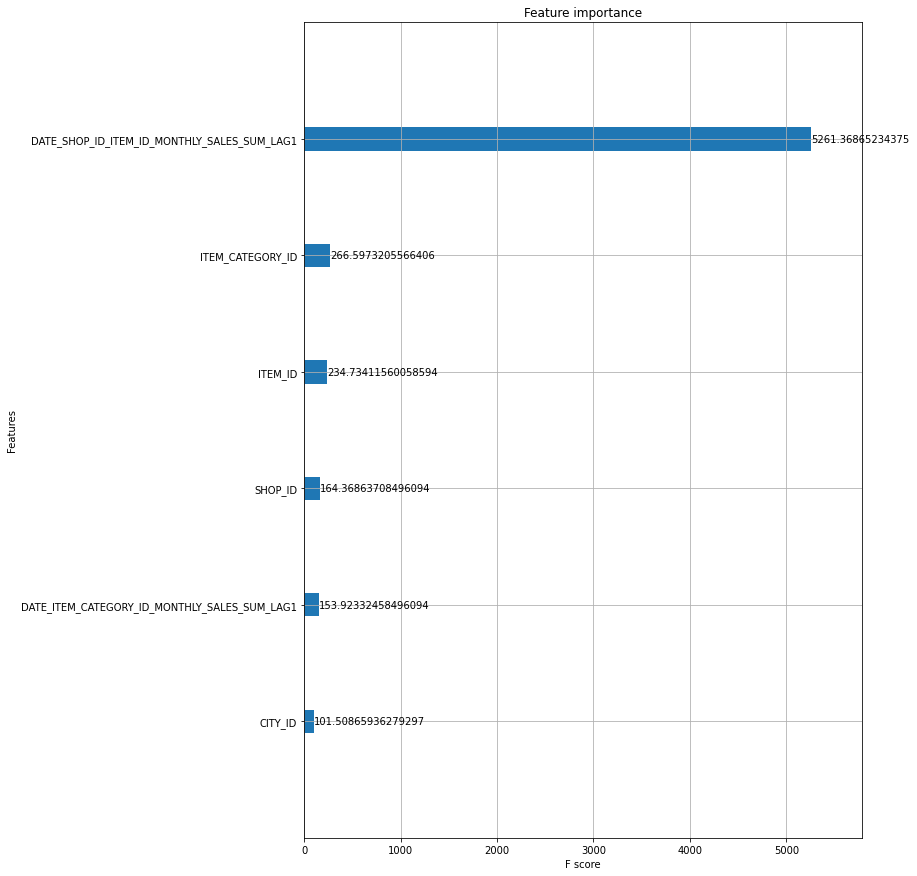

In [65]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

In [66]:
#validation_0-rmse:2.00901	validation_1-rmse:2.04388 --> total_transactions MAL EN KAGGKE
#validation_0-rmse:1.81873	validation_1-rmse:2.11876 --> total_transactions + monthly_mean_price MAL EN KAGGLE 
#validation_0-rmse:0.84047	validation_1-rmse:1.49485--> agregue todas las varables numericas del df

#validation_0-rmse:4.83599	validation_1-rmse:4.94010 --> Category_id  KAGGLE OK
#validation_0-rmse:3.86253	validation_1-rmse:3.09888 --> GB Category_id y store_id MAL EN KAGGLE
#validation_0-rmse:5.18660	validation_1-rmse:4.32568--> dos variables nuevas, una gb category_id, otra gb store_id MAL EN KAGGLE



### Prediction

In this section we are going to use the trained model to make a prediction and then send the submit to Kaggle.

In [67]:
last_trained_model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

In [68]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = np.sqrt(mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

4.798153768166372